<h2> Model : trained with (1058, 1058) size images, then resized to (224, 224) </h2>

<h1> 2D QPI </h1>

In [2]:
# Initialize
from torch_tomogram_dataset import AugmentedDatasetWrapper, TomogramDataset2DQPI
from torch_tomogram_dataset.utils import calculate_dataset_mean_std
from torchvision import models
from torch.utils.data import DataLoader

# Paths to training and validation directories
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\train"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\test"
train_dataset = TomogramDataset2DQPI(root_dir=train_dir, rescale=True)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)
# mean, std = calculate_dataset_mean_std(loader=train_loader)

In [13]:
mean = [0.1928, 0.1928, 0.1928]
std = [0.1029, 0.1029, 0.1029]

In [1]:
from torch_tomogram_dataset import AugmentedDatasetWrapper, TomogramDataset2DQPI
from torchvision import models, transforms
from torch.utils.data import DataLoader

# Paths to training and validation directories
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\train"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\test"

# Create datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = TomogramDataset2DQPI(root_dir=train_dir, rescale=True, transform=transform, augmentation=True, gaussian=True)
val_dataset = TomogramDataset2DQPI(root_dir=val_dir, rescale=True, transform=transform, augmentation=False, gaussian=True)

# Wrap datasets with the augmentation wrapper to repeat samples 3 times
augmented_train_dataset = AugmentedDatasetWrapper(train_dataset, num_repeats=3)
augmented_val_dataset = AugmentedDatasetWrapper(val_dataset, num_repeats=1)

# Create DataLoaders
train_loader = DataLoader(augmented_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(augmented_val_dataset, batch_size=16, shuffle=True)

In [2]:
images, labels = next(iter(train_loader))

c:\miniconda3\envs\cell\Lib\site-packages\torchio\data\image.py:251: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


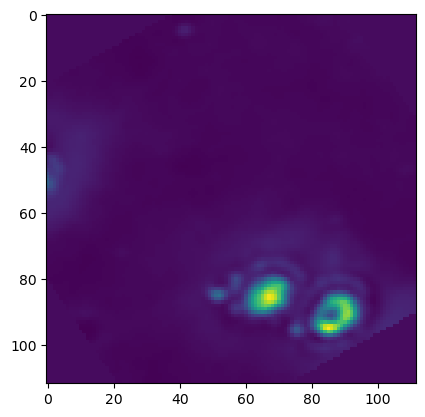

In [7]:
import matplotlib.pyplot as plt
plt.imshow(images[0][0][20])

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

model = models.video.r3d_18(weights=models.video.R3D_18_Weights.DEFAULT)

# Freeze parameters except last layer(fc layer)
for name, param in model.named_parameters():
    if 'fc' in name or 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the final layer for binary classification (2 classes: live, dead)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Mixed Precision Training
scaler = torch.amp.GradScaler()

# Optional: Print the model's trainable parameters to verify the setup
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 24909826


In [10]:
from tqdm import tqdm
from torch import amp
# Model save path
path = r"C:/rkka_Projects/cell_death_v1/finetuning/assay/gaussian_noise/3d/"
mode = '3d'

# Training loop
num_epochs = 15
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda'):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print training stats
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")
    
    # Save model for this epoch with validation accuracy in the filename
    model_filename = path + mode + f'_model_epoch_{epoch+1}_val_acc_{val_acc:.2f}.pth'
    torch.save(model.state_dict(), model_filename)

# Save accuracies
qpi_train_accuracies = train_accuracies
with open(mode + "_train_accuracies.txt", "w") as file:
    for item in qpi_train_accuracies:
        file.write(f"{item}\n")

qpi_val_accuracies = val_accuracies
with open(mode + "_val_accuracies.txt", "w") as file:
    for item in qpi_val_accuracies:
        file.write(f"{item}\n")

print("Training complete!")

  0%|          | 0/15 [00:00<?, ?it/s]c:\miniconda3\envs\cell\Lib\site-packages\torchio\data\image.py:251: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


Epoch [1/15], Loss: 0.2567, Accuracy: 91.54%
Validation Loss: 0.3035, Validation Accuracy: 88.39%



  7%|▋         | 1/15 [02:57<41:30, 177.92s/it]

Epoch [2/15], Loss: 0.1189, Accuracy: 96.39%
Validation Loss: 0.2093, Validation Accuracy: 90.18%



 13%|█▎        | 2/15 [05:57<38:46, 178.99s/it]

Epoch [3/15], Loss: 0.0847, Accuracy: 97.39%
Validation Loss: 0.3548, Validation Accuracy: 93.75%



 20%|██        | 3/15 [09:03<36:23, 181.95s/it]

Epoch [4/15], Loss: 0.0788, Accuracy: 97.14%
Validation Loss: 0.5265, Validation Accuracy: 85.71%



 27%|██▋       | 4/15 [12:12<33:54, 184.98s/it]

Epoch [5/15], Loss: 0.1471, Accuracy: 95.40%
Validation Loss: 0.6688, Validation Accuracy: 75.00%



 33%|███▎      | 5/15 [15:19<30:56, 185.61s/it]

Epoch [6/15], Loss: 0.0919, Accuracy: 97.01%
Validation Loss: 0.0943, Validation Accuracy: 99.11%



 40%|████      | 6/15 [18:27<27:57, 186.38s/it]

Epoch [7/15], Loss: 0.0567, Accuracy: 98.01%


 47%|████▋     | 7/15 [21:37<25:01, 187.72s/it]

Validation Loss: 0.2256, Validation Accuracy: 91.07%

Epoch [8/15], Loss: 0.0605, Accuracy: 97.26%
Validation Loss: 2.5146, Validation Accuracy: 82.14%



 53%|█████▎    | 8/15 [25:08<22:00, 188.60s/it]


KeyboardInterrupt: 

(50.0, 100.0)

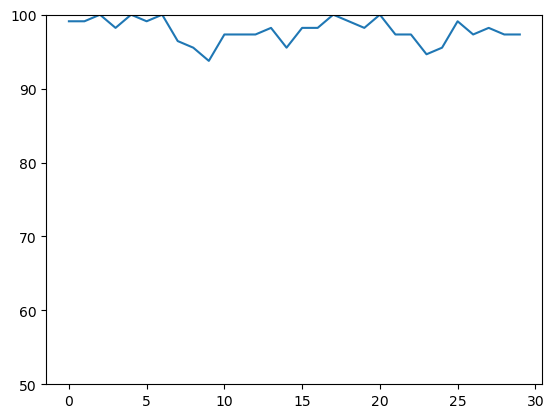

In [10]:
import matplotlib.pyplot as plt
qpi_accuracies = val_accuracies
plt.plot(qpi_accuracies)
plt.ylim(50, 100)

<h2> Timelapse assay </h2>

In [17]:
import torch
from torchvision import models

# Load your pretrained model
checkpoint = r"C:\rkka_Projects\cell_death_v1\finetuning\assay\2d_qpi\qpi_model_epoch_5_val_acc_100.00.pth"

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # Update based on your model
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=2)  # Binary classification
model.load_state_dict(torch.load(checkpoint))
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")
model = model.to(device)

device is cuda


C:\Users\김민욱\AppData\Local\Temp\ipykernel_15944\2359171759.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


In [ ]:
from torch_tomogram_dataset import AugmentedDatasetWrapper, TomogramDataset2DQPI
from torchvision import models, transforms
from torch.utils.data import DataLoader
import tifffile
import numpy as np

# Paths to training and validation directories
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\timelapse\qpi\cropped"
file_path = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\timelapse\qpi\cropped\qpi_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03"
mean = [0.1928, 0.1928, 0.1928]
std = [0.1029, 0.1029, 0.1029]

# Create datasets
transform = transforms.Compose([
    transforms.Resize((214, 214)),
    transforms.Normalize(mean=mean, std=std)
])

timelapse_image = tifffile.imread(file_path)
timelapse_tensor = torch.zeros((timelapse_image.shape[0], 3, 214, 214))

for i, d in enumerate(timelapse_image):
    # Normalize and make 3 channels image : (3, H, W)
    d = (d-np.min(d))/(np.max(d) - np.min(d))
    d = np.stack([d] * 3, axis=0)
    # Conver to torch tensor with (N, C, H, W)
    d = torch.from_numpy(d)
    d = d.unsqueeze(0)
    d = transform(d)
    
    timelapse_tensor[i] = d

In [23]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# Timelapse data as a list of frames (numpy arrays)
timelapse_frames = [frame for frame in timelapse_tensor]  # Replace with your list of frames (each as a 2D or 3D array)

# Predict probabilities
dead_probabilities = []
with torch.no_grad():
    for frame in timelapse_frames:
        # Preprocess frame
        frame = frame.unsqueeze(0).to(device)  # Add batch dimension

        # Predict
        outputs = model(frame)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        dead_prob = probabilities[0, 0].item()  # Probability for the "dead" class : "dead" label is 0
        dead_probabilities.append(dead_prob)

# Convert to a numpy array for analysis
dead_probabilities = np.array(dead_probabilities)

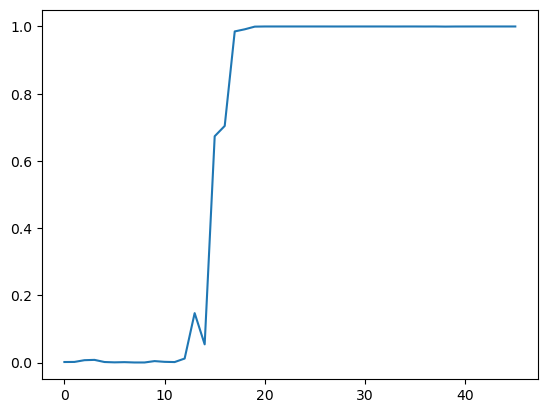

In [25]:
import matplotlib.pyplot as plt
plt.plot(dead_probabilities)

In [26]:
import napari
viewer = napari.Viewer()

<h1> 2D MIP </h1>

In [10]:
# Initialize
from torch_tomogram_dataset import AugmentedDatasetWrapper, TomogramDataset2DMIP
from torch_tomogram_dataset.utils import calculate_dataset_mean_std
from torchvision import models
from torch.utils.data import DataLoader

# Paths to training and validation directories
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\train"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\test"
train_dataset = TomogramDataset2DMIP(root_dir=train_dir, rescale=True)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)
mean, std = calculate_dataset_mean_std(loader=train_loader)

Mean: tensor([0.0620, 0.0620, 0.0620])
Std: tensor([0.0835, 0.0835, 0.0835])


In [15]:
mean = [0.0620, 0.0620, 0.0620]
std = [0.0835, 0.0835, 0.0835]

In [16]:
from torch_tomogram_dataset import AugmentedDatasetWrapper, TomogramDataset2DMIP
from torchvision import models
from torch.utils.data import DataLoader

# Paths to training and validation directories
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\train"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\test"

# Create datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])
train_dataset = TomogramDataset2DMIP(root_dir=train_dir, rescale=True, transform=transform, augmentation=True)
val_dataset = TomogramDataset2DMIP(root_dir=val_dir, rescale=True, transform=transform, augmentation=False)

# Wrap datasets with the augmentation wrapper to repeat samples 3 times
augmented_train_dataset = AugmentedDatasetWrapper(train_dataset, num_repeats=3)
augmented_val_dataset = AugmentedDatasetWrapper(val_dataset, num_repeats=1)

# Create DataLoaders
train_loader = DataLoader(augmented_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(augmented_val_dataset, batch_size=16, shuffle=True)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze parameters except last layer(fc layer)
for name, param in model.named_parameters():
    if 'fc' in name or 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the final layer for binary classification (2 classes: live, dead)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = torch.amp.GradScaler()

# Optional: Print the model's trainable parameters to verify the setup
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 14968834


In [18]:
from tqdm import tqdm

# model save path
path = r"C:/rkka_Projects/cell_death_v1/finetuning/2d_mip/"
mode = 'mip'

# Training loop
num_epochs = 20
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda'):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print training stats
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    train_accuracies.append(train_acc)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")

    # Save model for this epoch with validation accuracy in the filename
    model_filename = path + mode + f'_model_epoch_{epoch+1}_val_acc_{val_acc:.2f}.pth'
    torch.save(model.state_dict(), model_filename)

# Save accuracies
mip_train_accuracies = train_accuracies
with open("mip_train_accuracies.txt", "w") as file:
    for item in mip_train_accuracies:
        file.write(f"{item}\n")
        
mip_val_accuracies = val_accuracies
with open("mip_val_accuracies.txt", "w") as file:
    for item in mip_val_accuracies:
        file.write(f"{item}\n")

print("Training complete!")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.1456, Accuracy: 94.15%


  5%|▌         | 1/20 [01:40<31:53, 100.71s/it]

Validation Loss: 0.3058, Validation Accuracy: 91.07%

Epoch [2/20], Loss: 0.0721, Accuracy: 97.64%


 10%|█         | 2/20 [03:21<30:12, 100.68s/it]

Validation Loss: 0.1934, Validation Accuracy: 95.54%

Epoch [3/20], Loss: 0.0764, Accuracy: 97.39%


 15%|█▌        | 3/20 [05:02<28:35, 100.90s/it]

Validation Loss: 0.0750, Validation Accuracy: 98.21%

Epoch [4/20], Loss: 0.0880, Accuracy: 96.89%


 20%|██        | 4/20 [06:43<26:53, 100.82s/it]

Validation Loss: 0.0763, Validation Accuracy: 98.21%

Epoch [5/20], Loss: 0.0961, Accuracy: 97.26%


 25%|██▌       | 5/20 [08:24<25:15, 101.01s/it]

Validation Loss: 0.1215, Validation Accuracy: 98.21%

Epoch [6/20], Loss: 0.0940, Accuracy: 97.01%


 30%|███       | 6/20 [10:05<23:33, 101.00s/it]

Validation Loss: 0.1006, Validation Accuracy: 98.21%

Epoch [7/20], Loss: 0.0512, Accuracy: 97.76%


 35%|███▌      | 7/20 [11:46<21:51, 100.92s/it]

Validation Loss: 0.0961, Validation Accuracy: 98.21%



 35%|███▌      | 7/20 [11:51<22:01, 101.67s/it]


KeyboardInterrupt: 

(50.0, 100.0)

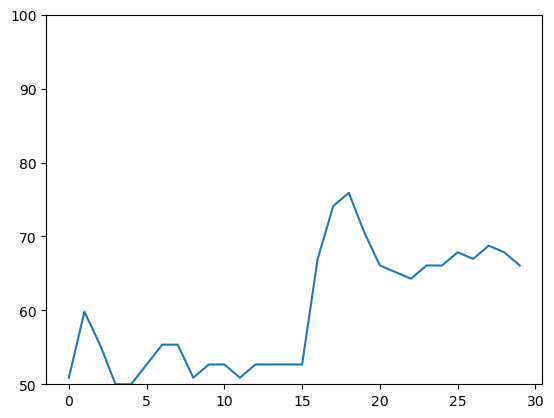

In [5]:
import matplotlib.pyplot as plt
mip_accuracies = val_accuracies
plt.plot(val_accuracies)
plt.ylim(50, 100)

<h1> 3D CNN </h1>

In [1]:
# Initialize
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch.optim as optim
from torch_tomogram_dataset import AugmentedDatasetWrapper, Simple3DCNNDataset
from torch_tomogram_dataset.utils import calculate_dataset_mean_std_3d
from torch.utils.data import DataLoader

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(Simple3DCNN, self).__init__()
        
        # 1st Convolution Block
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2)  # halves the spatial dims
        )
        
        # 2nd Convolution Block
        self.conv2 = nn.Sequential(
            nn.Conv3d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2)
        )
        
        # 3rd Convolution Block
        self.conv3 = nn.Sequential(
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2)
        )
        
        # After three poolings, each dimension is reduced by 2^3 = 8.
        # If your original shape is (D=60, H=1024, W=1024), 
        # the shape after these blocks is approx (32, 60/8, 1024/8, 1024/8).
        # That’s roughly (32, 7 or 8, 128, 128) if you didn’t crop or downsample earlier.
        # This is still huge, so you’ll likely need further downsizing.

        # For demonstration, let’s assume you have downsampled your volume 
        # to shape (1, 60, 128, 128) before feeding it in.
        # Then your feature map shape after the last block:
        #   (batch_size, 32, 60/8=~7, 128/8=16, 128/8=16).

        # Example: flattening
        self.fc = nn.Sequential(
            # nn.Linear(32 * 4 * 64 * 64, 256),  # adapt if your downsample shape differs
            nn.Linear(401408, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, 1, D, H, W)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock3D(nn.Module):
    """
    A simple 3D residual block:
      - conv -> bn -> relu -> conv -> bn
      - skip connection from input to output
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm3d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm3d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # if dimension changed (e.g., channel or spatial due to stride)
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        return out

class Deeper3DCNN(nn.Module):
    """
    A deeper 3D CNN with some residual blocks.
    Just an example—adapt the block counts, channels, etc. as you see fit.
    """
    def __init__(self, block=BasicBlock3D, layers=[2,2,2,2], num_classes=2):
        """
        layers: how many residual blocks in each layer
        """
        super(Deeper3DCNN, self).__init__()
        
        # Initial "stem" of the network
        self.in_channels = 32  # the number of channels after first conv
        self.conv1 = nn.Conv3d(1, 32, kernel_size=7, stride=(1,2,2), padding=3, bias=False)
        self.bn1   = nn.BatchNorm3d(32)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        # Layers (think of them like stages in a ResNet)
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # downsample
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # downsample
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # downsample
        
        # Final classification head
        # For a big input, you might get quite a small feature map at the end.
        # We'll flatten, then use a linear layer for classification.
        self.avgpool = nn.AdaptiveAvgPool3d((1,1,1)) 
        self.fc      = nn.Linear(512 * block.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        Create multiple residual blocks for one "layer" or stage.
        """
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * block.expansion),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x shape: [batch_size, 1, D, H, W]
        x = self.conv1(x)   # [batch_size, 32, D, H/2, W/2]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # [batch_size, 32, D/2, H/4, W/4]
        
        x = self.layer1(x)  # might keep D the same, reduce H/W if stride>1
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global average pooling
        x = self.avgpool(x) # [batch_size, 512, 1, 1, 1]
        
        x = torch.flatten(x, 1)  # [batch_size, 512]
        x = self.fc(x)           # [batch_size, num_classes]
        return x

# Quick test
# Suppose you have volumes sized [N, 1, 16, 128, 128] 
# (Depth=16, Height=128, Width=128), just as an example
model = Deeper3DCNN(num_classes=2)
dummy_input = torch.randn(2, 1, 16, 128, 128)  # batch_size=2
output = model(dummy_input)
print("Output shape:", output.shape)  # should be [2, 2]


Output shape: torch.Size([2, 2])


In [14]:
mean = 0.1492
std = 0.0312

# Paths to training and validation directories
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\train"  # Replace with your training directory
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\test"     # Replace with your validation directory

# Create datasets
transform = transforms.Normalize(mean, std)
train_dataset = Simple3DCNNDataset(root_dir=train_dir, rescale=True, transform=transform, augmentation=True)
val_dataset = Simple3DCNNDataset(root_dir=val_dir, rescale=True, transform=transform, augmentation=False)

augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)
augmented_val_dataset = AugmentedDatasetWrapper(dataset=val_dataset, num_repeats=1)

# Use DataLoader as usual
train_loader = DataLoader(augmented_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(augmented_val_dataset, batch_size=16, shuffle=True)

In [29]:
# 3. Instantiate model, loss, optimizer
model = Deeper3DCNN(num_classes=2)
model.load_state_dict(state_dict=torch.load(r'C:\rkka_Projects\cell_death_v1\finetuning\assay\3d\3d_cnn\3d_deeper_model_epoch_1_val_acc_98.21.pth'))
# model.load_state_dict(state_dict=torch.load(r'C:\rkka_Projects\cell_death_v1\finetuning\assay\3d\3d_cnn3d_model_epoch_2_val_acc_89.29.pth'))

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)  # if you have a GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scaler = torch.amp.GradScaler()

C:\Users\김민욱\AppData\Local\Temp\ipykernel_28344\177882110.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(state_dict=torch.load(r'C:\rkka_Projects\

In [30]:
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [31]:
# Optional: Print the model's trainable parameters to verify the setup
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 24909826


In [32]:
# Model save path
path = r"C:/rkka_Projects/cell_death_v1/finetuning/assay/3d/3d_cnn/deeper_finetune/"
mode = '3d_deeper'

# Training loop with validation
num_epochs = 30
train_accuracies = []
val_accuracies =[]

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()          # Backward pass
        scaler.step(optimizer)         # Update weights
        scaler.update()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    train_accuracies.append(epoch_acc)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_total = 0
    val_correct = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item() * val_inputs.size(0)
            
            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
    
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = 100 * val_correct / val_total
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% - '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')
    
    val_accuracies.append(val_epoch_acc)
    
    # Save model for this epoch with validation accuracy in the filename
    model_filename = path + mode + f'_model_epoch_{epoch+1}_val_acc_{val_epoch_acc:.2f}.pth'
    torch.save(model.state_dict(), model_filename)
    
# Save accuracies
three_dim_val_accuracies = val_accuracies
with open("3d_val_accuracies.txt", "w") as file:
    for item in three_dim_val_accuracies:
        file.write(f"{item}\n")

print("Training complete!")

Epoch 1/30 - Train Loss: 0.3786, Train Acc: 96.39% - Val Loss: 0.1614, Val Acc: 94.64%
Epoch 2/30 - Train Loss: 0.3792, Train Acc: 96.14% - Val Loss: 0.2307, Val Acc: 91.96%
Epoch 3/30 - Train Loss: 0.3059, Train Acc: 96.89% - Val Loss: 0.5488, Val Acc: 81.25%
Epoch 4/30 - Train Loss: 0.2299, Train Acc: 97.51% - Val Loss: 0.4323, Val Acc: 83.93%
Epoch 5/30 - Train Loss: 0.2388, Train Acc: 97.14% - Val Loss: 0.7278, Val Acc: 78.57%
Epoch 6/30 - Train Loss: 0.1955, Train Acc: 98.26% - Val Loss: 0.6489, Val Acc: 77.68%


RuntimeError: Exception thrown in SimpleITK ResampleImageFilter_Execute: D:\a\SimpleITK\SimpleITK\bld\ITK-prefix\include\ITK-5.4\itkImportImageContainer.hxx:179:
Failed to allocate memory for image.

In [7]:
inputs.shape

torch.Size([1, 16, 1, 448, 448])

In [8]:
images, labels = next(iter(train_loader))

c:\miniconda3\envs\cell\Lib\site-packages\torchio\data\image.py:251: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


In [9]:
images.shape

torch.Size([16, 1, 32, 448, 448])

<h1> 3D ResNet 18 </h1>

In [3]:
# Initialize
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch.optim as optim
from torch_tomogram_dataset import AugmentedDatasetWrapper, TomogramDataset3D
from torch_tomogram_dataset.utils import calculate_dataset_mean_std_3d
from torch.utils.data import DataLoader

In [ ]:
# Initialize

# Paths to training and validation directories
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\train"
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\test"
train_dataset = TomogramDataset3D(root_dir=train_dir, rescale=True)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)
mean, std = calculate_dataset_mean_std_3d(loader=train_loader)

c:\miniconda3\envs\cell\Lib\site-packages\torchio\data\image.py:251: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


Mean: tensor([0.1492])
Std: tensor([0.0312])


In [4]:
mean = 0.1492
std = 0.0312

In [5]:
# Paths to training and validation directories
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\train"  # Replace with your training directory
val_dir = r"C:\rkka_Projects\cell_death_v1\Data\live_dead\start_end_only\test"     # Replace with your validation directory

# Create datasets
transform = transforms.Normalize(mean, std)
train_dataset = TomogramDataset3D(root_dir=train_dir, rescale=True, transform=transform, augmentation=True)
val_dataset = TomogramDataset3D(root_dir=val_dir, rescale=True, transform=transform, augmentation=False)

augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)
augmented_val_dataset = AugmentedDatasetWrapper(dataset=val_dataset, num_repeats=1)

# Use DataLoader as usual
train_loader = DataLoader(augmented_train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(augmented_val_dataset, batch_size=16, shuffle=True)

In [6]:
images, labels = next(iter(train_loader))

c:\miniconda3\envs\cell\Lib\site-packages\torchio\data\image.py:251: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


In [7]:
images[0].shape

torch.Size([32, 3, 448, 448])

In [25]:
# Initialize the 3D ResNet model with pretrained weights
model = models.video.r3d_18(weights=models.video.R3D_18_Weights.DEFAULT)

# Modify the first convolution layer to accept single-channel input
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(2,7,7), stride=(1,2,2), padding=(1,3,3), bias=False)

# Modify the final fully connected layer to output 2 classes
model.fc = nn.Linear(in_features=512, out_features=2)

# Freeze the earlier layers (only fine-tune the last few layers)
for name, param in model.named_parameters():
    # Here, unfreeze the last few layers based on their names (e.g., fc layer or last blocks)
    if 'stem' in name or 'fc' in name or 'layer4' in name:  # Fine-tune the fully connected layer and the last block (layer4)
        param.requires_grad = True
    else:
        param.requires_grad = False


# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scaler = torch.amp.GradScaler()

# Optional: Print the model's trainable parameters to verify the setup
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 24916226


In [26]:
# Model save path
path = r"C:/rkka_Projects/cell_death_v1/finetuning/3d/"
mode = '3d'

# Training loop with validation
num_epochs = 30
train_accuracies = []
val_accuracies =[]

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()          # Backward pass
        scaler.step(optimizer)         # Update weights
        scaler.update()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    train_accuracies.append(epoch_acc)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_total = 0
    val_correct = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item() * val_inputs.size(0)
            
            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
    
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = 100 * val_correct / val_total
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% - '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')
    
    val_accuracies.append(val_epoch_acc)
    
    # Save model for this epoch with validation accuracy in the filename
    model_filename = path + mode + f'_model_epoch_{epoch+1}_val_acc_{val_epoch_acc:.2f}.pth'
    torch.save(model.state_dict(), model_filename)
    
# Save accuracies
three_dim_val_accuracies = val_accuracies
with open("3d_val_accuracies.txt", "w") as file:
    for item in three_dim_val_accuracies:
        file.write(f"{item}\n")

print("Training complete!")

c:\miniconda3\envs\cell\Lib\site-packages\torchio\data\image.py:251: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


Epoch 1/30 - Train Loss: 0.8681, Train Acc: 86.82% - Val Loss: 0.3010, Val Acc: 87.50%
Epoch 2/30 - Train Loss: 0.3302, Train Acc: 96.77% - Val Loss: 0.1654, Val Acc: 93.75%
Epoch 3/30 - Train Loss: 0.2098, Train Acc: 97.51% - Val Loss: 0.1564, Val Acc: 92.86%


: 

<h1> Confusion Matrix </h1>

C:\Users\김민욱\AppData\Local\Temp\ipykernel_22388\3911247327.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(state_dict=torch.load(r"C:\rkka_Project

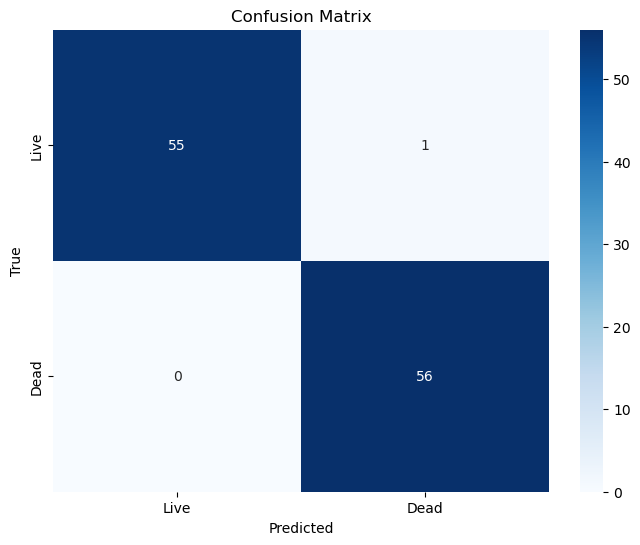

In [21]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch_tomogram_dataset import TomogramDataset2DQPI, TomogramDataset2DMIP, TomogramDataset3D
from torchvision import transforms

mean = [0.0620, 0.0620, 0.0620]
std = [0.0835, 0.0835, 0.0835]

# Create datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])

val_dataset = TomogramDataset2DMIP(root_dir=val_dir, rescale=True, transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)

# Initialize the 3D ResNet model with pretrained weights
model = models.resnet50()

# Modify the final layer for binary classification (2 classes: live, dead)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)

model.load_state_dict(state_dict=torch.load(r"C:\rkka_Projects\cell_death_v1\finetuning\2d_mip\mip_model_epoch_7_val_acc_98.21.pth"))

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# After training, collect predictions and actual labels from the validation set
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Live', 'Dead'], yticklabels=['Live', 'Dead'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


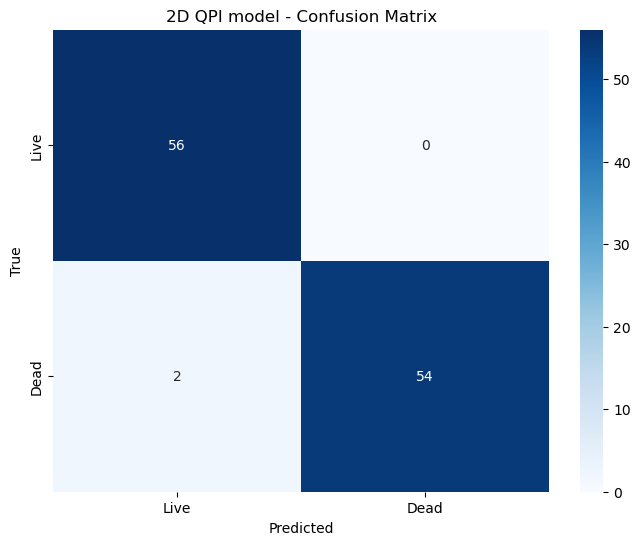

In [14]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Live', 'Dead'], yticklabels=['Live', 'Dead'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('2D QPI model - Confusion Matrix')
plt.show()
